In [1]:
# !git clone https://github.com/deepmind/dsprites-dataset.git

In [2]:
import tensorflow as tf 
tf.enable_eager_execution()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools

In [4]:
## Code from Deepmind's Github
load_data = np.load("dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
imgs = load_data['imgs']
latents_values = load_data['latents_values']
latents_classes = load_data['latents_classes']
metadata = load_data['metadata'][()]

print('Metadata: \n', metadata)

Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.18879

In [5]:
latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

def show_images_grid(imgs_, num_images=25, cmap='Greys_r'):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            if not cmap is None:
                ax.imshow(imgs_[ax_i], cmap=cmap,  interpolation='nearest')
            else:
                ax.imshow(imgs_[ax_i]*255, interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

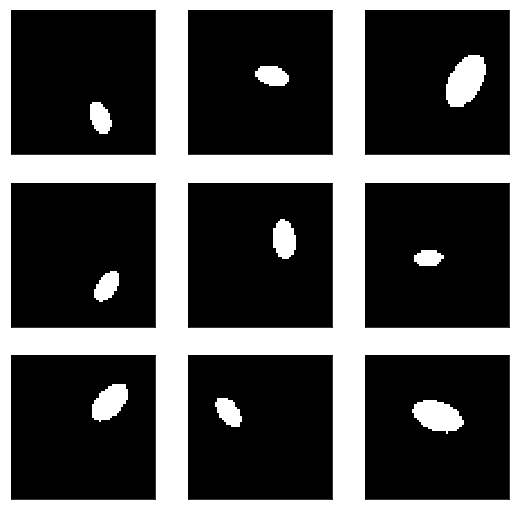

In [6]:
latents_sampled = sample_latent(size=60000)
latents_sampled[:, 1] = 1
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

show_images_grid(imgs_sampled, 9, cmap='gray')

In [7]:
imgs_sampled[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
def create_color(base_image):
    all_color = itertools.product([0, 1], repeat=3)
    all_images = []
    for r, g, b in all_color:
        if (r, g, b) == (0, 0, 0):
            continue
        new_color = np.stack([
            base_image*r,
            base_image*g,
            base_image*b
        ], axis=-1)

        all_images.append(new_color)
    return all_images

In [9]:
all_images_color = []

for i, img in enumerate(imgs_sampled):
    if i%10000 == 0:
        print(f"Now at {i}/{imgs_sampled.shape[0]}")
    all_images_color += create_color(img)
    
imgs_sampled_color = np.stack(all_images_color)
imgs_sampled_color.shape

Now at 0/60000
Now at 10000/60000
Now at 20000/60000
Now at 30000/60000
Now at 40000/60000
Now at 50000/60000


(420000, 64, 64, 3)

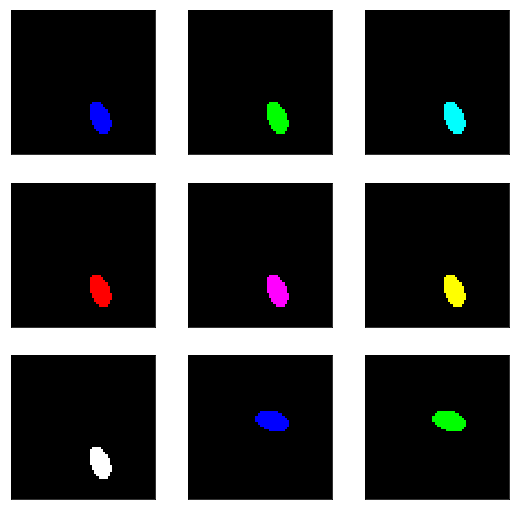

In [10]:
show_images_grid(imgs_sampled_color, 9, cmap=None)

In [11]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(imgs_sampled_color).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [13]:
class VAESprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(4, 4), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
        
    def sample(self):
        latent = tf.random_normal(shape=(1, self.latent_dim))
        return latent, tf.nn.sigmoid(self.decoder(latent))
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        mean, log_var = tf.split(self.encoder(img), num_or_size_splits=2, axis=1)
        
        normal = tf.random_normal(shape=mean.shape)
        latent = normal * tf.exp(log_var * .5) + mean
        
        out = self.decoder(latent)
        if is_sigmoid:
            out = tf.nn.sigmoid(out)
        return latent, out, mean, log_var

In [14]:
vae = VAESprite(10)

In [15]:
optimizer = tf.train.AdamOptimizer(5e-5)

for e in range(5):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        img = tf.cast(img, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var = vae(img)
            
            # Reconstruction loss ? 
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            
            # KL Loss -- From https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[1])
            
            loss = -tf.reduce_mean(logpx_z - kl_loss)
            if i % 100 == 0:
                print(loss)

        grad = tape.gradient(loss, vae.variables)
        optimizer.apply_gradients(zip(grad, vae.variables))
    print("---------")   

At epoch 0
tf.Tensor(8517.414, shape=(), dtype=float32)
tf.Tensor(5196.537, shape=(), dtype=float32)
tf.Tensor(2287.0188, shape=(), dtype=float32)
tf.Tensor(1867.7388, shape=(), dtype=float32)
tf.Tensor(1563.6825, shape=(), dtype=float32)
tf.Tensor(1575.2919, shape=(), dtype=float32)
tf.Tensor(1442.1438, shape=(), dtype=float32)
tf.Tensor(1202.5958, shape=(), dtype=float32)
tf.Tensor(1031.4033, shape=(), dtype=float32)
tf.Tensor(853.33026, shape=(), dtype=float32)
tf.Tensor(841.6078, shape=(), dtype=float32)
tf.Tensor(760.8222, shape=(), dtype=float32)
tf.Tensor(690.1741, shape=(), dtype=float32)
tf.Tensor(660.9972, shape=(), dtype=float32)
tf.Tensor(636.57214, shape=(), dtype=float32)
tf.Tensor(616.11597, shape=(), dtype=float32)
tf.Tensor(607.46124, shape=(), dtype=float32)
tf.Tensor(574.17505, shape=(), dtype=float32)
tf.Tensor(529.2573, shape=(), dtype=float32)
tf.Tensor(553.6482, shape=(), dtype=float32)
tf.Tensor(561.498, shape=(), dtype=float32)
tf.Tensor(534.683, shape=(), dtyp

tf.Tensor(176.76675, shape=(), dtype=float32)
tf.Tensor(171.2144, shape=(), dtype=float32)
tf.Tensor(155.35019, shape=(), dtype=float32)
tf.Tensor(157.58345, shape=(), dtype=float32)
tf.Tensor(152.39252, shape=(), dtype=float32)
tf.Tensor(147.40456, shape=(), dtype=float32)
tf.Tensor(147.3188, shape=(), dtype=float32)
tf.Tensor(142.01367, shape=(), dtype=float32)
tf.Tensor(136.86984, shape=(), dtype=float32)
tf.Tensor(133.00983, shape=(), dtype=float32)
tf.Tensor(126.90627, shape=(), dtype=float32)
tf.Tensor(131.36964, shape=(), dtype=float32)
tf.Tensor(131.23312, shape=(), dtype=float32)
tf.Tensor(134.75983, shape=(), dtype=float32)
tf.Tensor(120.87576, shape=(), dtype=float32)
tf.Tensor(130.9976, shape=(), dtype=float32)
tf.Tensor(122.54425, shape=(), dtype=float32)
tf.Tensor(120.20372, shape=(), dtype=float32)
tf.Tensor(119.43106, shape=(), dtype=float32)
tf.Tensor(114.13122, shape=(), dtype=float32)
tf.Tensor(113.09897, shape=(), dtype=float32)
tf.Tensor(112.57261, shape=(), dtype=

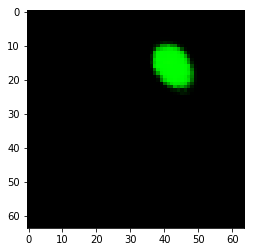

In [16]:
plt.imshow(tf.nn.sigmoid(out[4]).numpy())

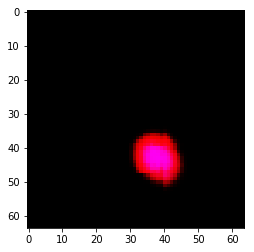

In [17]:
sampled_latent, img = vae.sample()
img = tf.squeeze(img)

plt.imshow(img.numpy())

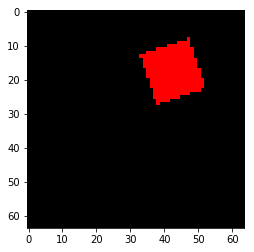

In [18]:
latents_sampled = sample_latent(size=1)

latents_sampled[:, 1] = 0
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

test_img = imgs_sampled[0]
test_color_img = create_color(test_img)
plt.imshow(test_color_img[3]*255)

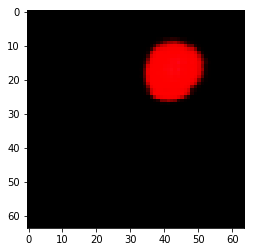

In [19]:
test_color_img_single = tf.expand_dims(tf.convert_to_tensor(test_color_img[3]), axis=0)
latent, out, _, _ = vae(tf.cast(test_color_img_single, tf.float32))

out = tf.squeeze(tf.nn.sigmoid(out))
plt.imshow(out.numpy())

In [20]:
diff = latent - sampled_latent
number_steps = 10
diff = diff/number_steps 
diff

<tf.Tensor: id=9031325, shape=(1, 10), dtype=float32, numpy=
array([[ 0.07234307, -0.17965749,  0.2055933 ,  0.11410501,  0.02619842,
        -0.00808794, -0.03219842, -0.1338965 , -0.17152627,  0.1010346 ]],
      dtype=float32)>

In [21]:
middle = sampled_latent
frames = []
for i in range(number_steps):
    out = tf.nn.sigmoid(vae.decoder(middle))
    out = tf.squeeze(out)
    frames.append(out.numpy())
    middle += diff

frames = np.stack(frames)
frames.shape

(10, 64, 64, 3)

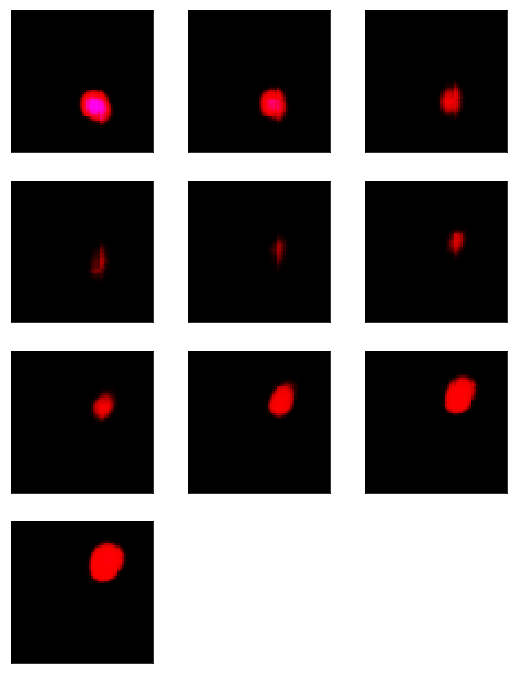

In [22]:
show_images_grid(frames, num_images=10)

In [23]:
def traverse_latent(latent, axis, traverse_length=9, total_step=9):
    step_size = traverse_length * 2 / total_step
    item = latent[:, axis]
    
    item_evolution = []
    item = item - traverse_length
    import copy
    for i in range(total_step):
        new_latent = copy.deepcopy(latent)
        new_latent[:, axis] = item
        item_evolution.append(new_latent)
        item += step_size
        
    traversed_latent = np.squeeze(np.stack(item_evolution))
    return traversed_latent

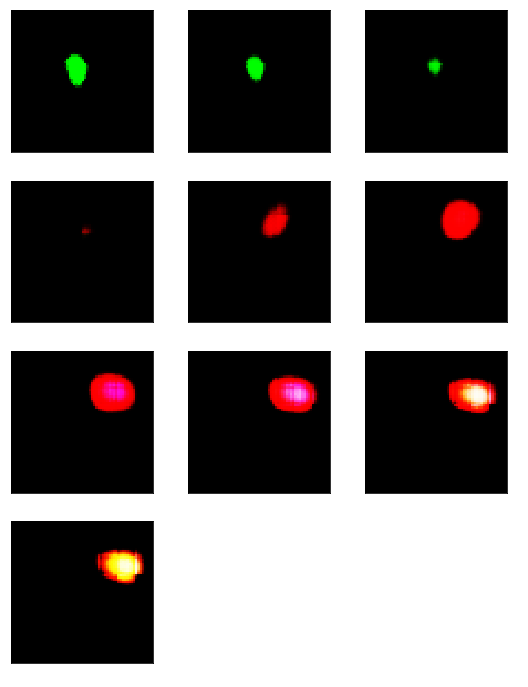

In [28]:
all_latent = traverse_latent(latent.numpy(), 0, total_step=10)
out = vae.decoder(tf.convert_to_tensor(all_latent))
out = tf.squeeze(tf.nn.sigmoid(out))

show_images_grid(out.numpy(), 10)